# Modelo propuesto (Híbrido)

In [18]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from itertools import product
from tqdm import tqdm
import os
import keras.backend as K
import statsmodels.api as sm
import tensorflow as tf

from scipy import stats
import gc
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using GPU.")
    for gpu in gpus:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU details: {gpu_details}")
else:
    print("TensorFlow is not using GPU.")

TensorFlow is using GPU.
GPU details: {'device_name': 'NVIDIA GeForce RTX 2060 SUPER', 'compute_capability': (7, 5)}


In [3]:
df = pd.read_csv('../../data/consumo_silver.csv')
df = df.iloc[:-1] # se omite el primer dato porque está incompleto
df.drop(columns="FESTIVO", inplace=True)
df['ds'] = pd.to_datetime(df['DateTime'])
df['y'] = df['CONSUMO']
# data = df[["ds","y",""]].copy()

In [4]:
df = pd.concat([df, pd.get_dummies(df["TIPO_DIA"])*1],axis=1)

In [5]:
df.head()

,DateTime,CONSUMO,TIPO_DIA,DIA_SEM,MES,AÑO,PANDEMIA,ds,y,FESTIVO,NORMAL
0,2014-01-01,1025.77354,FESTIVO,2,1,2014,0,2014-01-01,1025.77354,1,0
1,2014-01-02,1478.33453,NORMAL,3,1,2014,0,2014-01-02,1478.33453,0,1
2,2014-01-03,1610.05269,NORMAL,4,1,2014,0,2014-01-03,1610.05269,0,1
3,2014-01-04,1578.83430,NORMAL,5,1,2014,0,2014-01-04,1578.83430,0,1
4,2014-01-05,1328.31417,NORMAL,6,1,2014,0,2014-01-05,1328.31417,0,1


## SARIMAX

Por la estacionalidad observada, se propone la la construción de un modelo SARIMAX.

Inicialmente se realiza la división de los datos en test, train y validación.

In [138]:
len_test = 14 # días para test

n_datos = len(df)
train_serie = df["y"].iloc[:-len_test*2]
val_serie = df["y"].iloc[-len_test*2:-len_test]
test_serie= df["y"].iloc[-len_test:]

exo_var_train = df["FESTIVO"].iloc[:-len_test*2]
exo_var_val = df["FESTIVO"].iloc[-len_test*2:-len_test]
exo_var_test = df["FESTIVO"].iloc[-len_test:]

In [53]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_serie)
print('Estadístico ADF:', result[0])
print('Valor p:', result[1])


Estadístico ADF: -7.555931337867959
Valor p: 3.0996679573954175e-11


Dado que se  obtiene un P-value menor a 0.05, se puede concluir que los datos son estacionarios

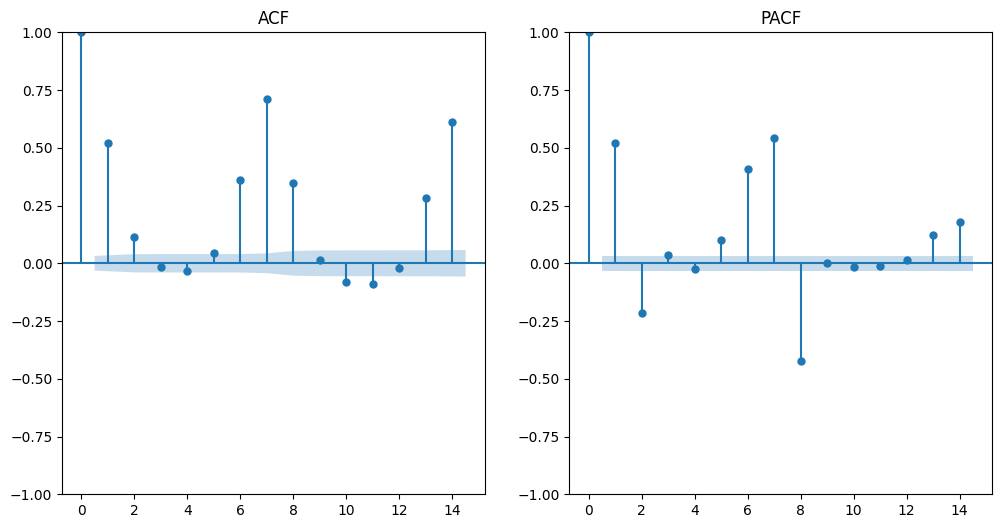

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(train_serie, lags=14, ax=plt.gca())
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(train_serie, lags=14, ax=plt.gca())
plt.title('PACF')
plt.show()

A continuación buscamos los parámetros con los datos de validación:

In [67]:
def train_sarimax(train_data, exog_train, order, seasonal_order):
    """
    Entrena el modelo SARIMAX 
    """
    model = SARIMAX(train_data,
                    exog=exog_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)
    return results

# Define los rangos para p, d, q
p = d = q = range(0, 3)
pdq = list(product(p, d, q))

# Para modelos estacionales
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]  # Estacionalidad semanal


all_params = list(product(pdq, seasonal_pdq))

aic_values = []
parameters = []

for param in tqdm(all_params):
    try:
        # Ajustar el modelo SARIMAX
        #model = SARIMAX(data['valor'], order=param[0], seasonal_order=param[1])
        results = train_sarimax(val_serie, exo_var_val, param[0], param[1])
        aic_values.append(results.aic)
        parameters.append(param)
    except Exception as e:
        continue

# Seleccionar el modelo con menor AIC
index_min = np.argmin(aic_values)
best_param, best_seasonal_param = parameters[index_min]

100%|██████████| 729/729 [00:21<00:00, 33.67it/s]


In [31]:
# De las varias iteraciones que se han realidado
mejores_parametros_encontrados = [(1, 0, 2), (0, 1, 2, 7)]

In [139]:
model = SARIMAX(train_serie,
                    exog=exo_var_train,
                    order=(1, 0, 2),
                    seasonal_order=(0, 1, 2, 7),
                    enforce_stationarity=False,
                    enforce_invertibility=False)

sarimax_fit = model.fit(disp=False)

In [89]:
sarimax_fit.save('models/modelo_sarimax_v2.pkl')

In [197]:
def calculate_metrics(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    metrics = {
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse,
        "MSE": rmse**2,
        "R2": r2_score(y_true, y_pred)
    }
    return metrics

In [198]:
model_summary = []

In [199]:
forecast = sarimax_fit.get_prediction(start=train_serie.index[0], end=train_serie.index[-1], exog=exo_var_train)
y_train_pred = forecast.predicted_mean

y_true, y_pred = train_serie,  y_train_pred
resultado_train = calculate_metrics(y_true, y_pred)
residuals_train = y_true - y_pred


model_summary.append(pd.DataFrame([resultado_train], index=["SARIMAX_train"]))
pd.DataFrame([resultado_train])


,MAPE,MAE,RMSE,MSE,R2
0,0.030635,53.308904,85.633482,7333.093303,0.816442


In [200]:
forecast = sarimax_fit.get_prediction(start=val_serie.index[0], end=val_serie.index[-1], exog=exo_var_val)
y_val_pred = forecast.predicted_mean

y_true, y_pred = val_serie,  y_val_pred
resultado_val = calculate_metrics(y_true, y_pred)
residuals_val = y_true - y_pred

model_summary.append(pd.DataFrame([resultado_val], index=["SARIMAX_val"]))
pd.DataFrame([resultado_val])

,MAPE,MAE,RMSE,MSE,R2
0,0.01347,24.684192,35.363633,1250.586568,0.927849


In [201]:
forecast = sarimax_fit.get_prediction(start=test_serie.index[0], end=test_serie.index[-1], exog=pd.concat([exo_var_val, exo_var_test]))
y_test_pred = forecast.predicted_mean

y_true, y_pred = test_serie,  y_test_pred
resultado_test = calculate_metrics(y_true, y_pred)
residuals_test = y_true - y_pred

model_summary.append(pd.DataFrame([resultado_test], index=["SARIMAX_test"]))
pd.DataFrame([resultado_test])

,MAPE,MAE,RMSE,MSE,R2
0,0.025891,44.925638,57.59351,3317.012375,0.895888


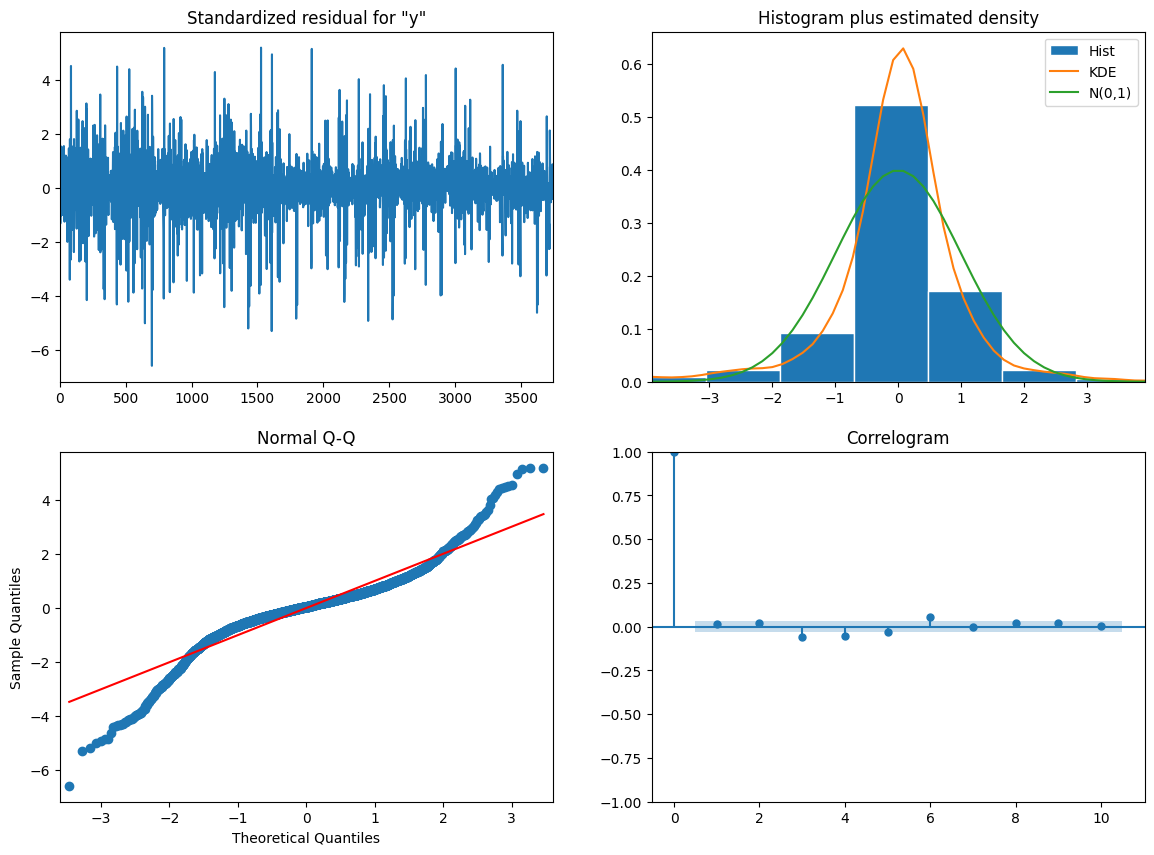

In [175]:
sarimax_fit.plot_diagnostics(figsize=(14,10));

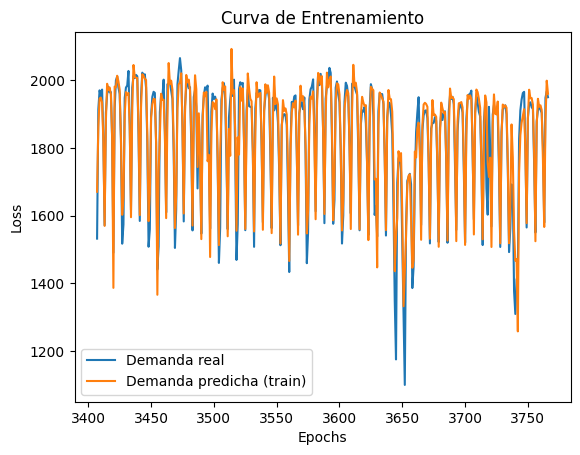

In [209]:
wd = 360

plt.figure()
plt.plot(train_serie.iloc[-wd:].index, train_serie.iloc[-wd:], label='Demanda real')
plt.plot(train_serie.iloc[-wd:].index, y_train_pred.iloc[-wd:], label='Demanda predicha (train)')
plt.title('Curva de Entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

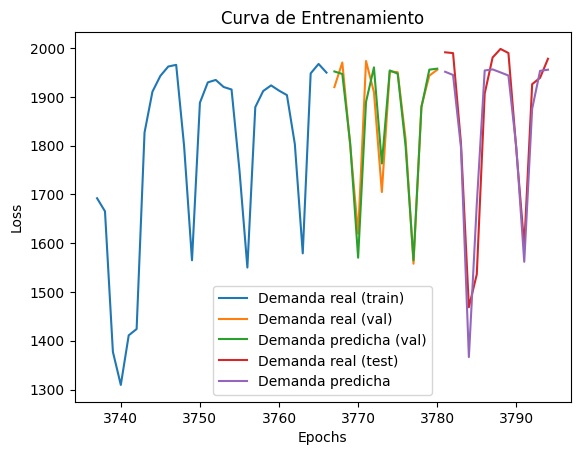

In [176]:
plt.figure()
plt.plot(train_serie.iloc[-30:].index, train_serie.iloc[-30:], label='Demanda real (train)')
plt.plot(val_serie.index, val_serie, label='Demanda real (val)')
plt.plot(val_serie.index, y_val_pred, label='Demanda predicha (val)')
plt.plot(test_serie.index, test_serie, label='Demanda real (test)')
plt.plot(test_serie.index, y_test_pred, label='Demanda predicha')
plt.title('Curva de Entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## LSTM // RNN

<Axes: >

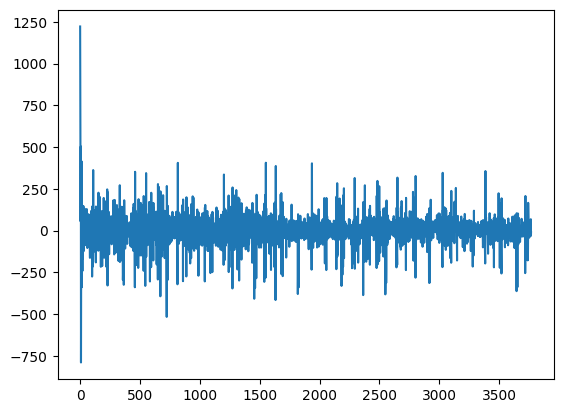

In [147]:
resid_serie = residuals_train
resid_serie.plot()

In [148]:
def split_time_series(data, tau, train_nrows, train_ncols=0):
    """
    train_ncols: Número de columnas para el train
    train_nrows: Número de filas para el train
    tau: número de rows y cols para val y test
    """
    n_samples = len(data)
    len_dim = train_nrows + tau * 2  # total filas por dim

    splits = []
    id_counter = 1
    dim = 1
    split_counter = 0

    for start in range(n_samples):
        if split_counter == 0:
            if start + len_dim > n_samples:
                break  # No hay suficientes datos
        
        current_dim_start_idx = len(splits)
        
        train_ncols = tau

        x_train_end = start + tau
        x_tau_end = start + train_ncols


        # Determinar el tipo de split
        if split_counter < train_nrows:
            split_type = "train"
            X_data = data.iloc[start:x_train_end].values.copy()  # Tomar train_ncols columnas
            y_data = data.iloc[x_train_end:x_train_end +1 ].values.copy()  # y correspondiente a train_nrows
        elif split_counter < train_nrows + tau:
            split_type = "val"
            X_data = data.iloc[start:x_train_end].values.copy()  # val: tau columnas
            y_data = data.iloc[x_tau_end:x_tau_end + 1].values.copy()  # y correspondiente al tau
        elif split_counter < len_dim:
            split_type = "test"
            X_data = data.iloc[start:x_train_end].values.copy()  # test: tau columnas
            y_data = data.iloc[x_tau_end:x_tau_end + 1].values.copy()  # y correspondiente al tau
        else:
            dim += 1
            split_counter = 0
            split_type = "train"
            continue
        if len(y_data) == 0:
            break  # algún muestra no tiene y, por tanto, no consideremos este dim

        split_dict = {
            "id": id_counter,
            "dim": dim,
            "split": split_type,
            "X": X_data,
            "y": y_data
        }

        splits.append(split_dict)

        # Contadores
        id_counter += 1
        split_counter += 1

        if split_counter >= len_dim:
            dim += 1
            split_counter = 0

    df = pd.DataFrame(splits)
    dim_ok = df["dim"].value_counts() == len_dim
    df_ok = df.loc[df["dim"].isin(dim_ok[dim_ok].index)].copy()
    return df_ok

In [149]:
tau_list = [7,14]
train_lens = [180,360]

datasets = {}

for tau, train_nrows in itertools.product(tau_list, train_lens):
    key = f"tau{tau}_train_rows{train_nrows}"
    dataset = split_time_series(data=resid_serie, tau=tau, train_nrows=train_nrows)
    datasets[key] = dataset

In [150]:
datasets.keys()

dict_keys(['tau7_train_rows180', 'tau7_train_rows360', 'tau14_train_rows180', 'tau14_train_rows360'])

In [422]:
datasets.get("tau14_train_rows360")

,id,dim,split,X,y
0,1,1,train,"[1227.078109292743, 923.0650376329579, 618.435...",[49.19118016422294]
1,2,1,train,"[923.0650376329579, 618.4356715183436, 347.809...",[-66.0997285318947]
2,3,1,train,"[618.4356715183436, 347.80924699763636, 26.147...",[148.79822693608412]
3,4,1,train,"[347.80924699763636, 26.14723310335262, 252.83...",[-92.79021604127888]
4,5,1,train,"[26.14723310335262, 252.83460624929126, 475.79...",[-57.61687501975507]
...,...,...,...,...,...
3487,3488,9,test,"[-59.401287223361805, -15.704979394911561, -10...",[37.79097496444433]
3488,3489,9,test,"[-15.704979394911561, -10.667037634989356, 15....",[0.2728034190006383]
3489,3490,9,test,"[-10.667037634989356, 15.413215258233095, 24.0...",[-6.241298711532181]
3490,3491,9,test,"[15.413215258233095, 24.00529719649694, -8.724...",[-50.71495463837505]


In [110]:
def plot_residuals(resid, save_path):
    """
    Genera y guarda una figura con tres subplots
    """
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    #Serie de Residuos
    axs[0].plot(resid, color='blue')
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_title('Serie de Residuos')
    axs[0].set_xlabel('Índice')
    axs[0].set_ylabel('Residuo')

    #QQPlot de Residuos
    sm.qqplot(resid, line='s', ax=axs[1])
    axs[1].set_title('QQPlot de Residuos')

    #ACF de Residuos
    plot_acf(resid, ax=axs[2], lags=min(20, len(resid)-1))
    axs[2].set_title('ACF de Residuos')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


def create_and_train_model(model_type, neurons, dropout_rate, batch_size, X_train, y_train, X_val, y_val, key, dim):
    model = Sequential()
    if model_type == 'RNN':
        #(samples, timesteps, features)
        model.add(SimpleRNN(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))
    elif model_type == 'LSTM':
        #(samples, timesteps, features)
        model.add(LSTM(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))
    else:
        raise ValueError("Modelo inválido")

    model.compile(optimizer=Adam(), loss='mse', metrics=['mape','mae', 'mse'])

    checkpoint_dir = f'models/{key}'
    os.makedirs(checkpoint_dir, exist_ok=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(
        f'{checkpoint_dir}/best_model_dim{dim}_{model_type}.h5',
        save_best_only=True,
        monitor='val_loss'
    )

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[early_stopping, model_checkpoint]
    )
    return model, history

# Definición de la función para procesar y entrenar modelos
def process_and_train_models(key, df_model, model_types, neurons, dropout_rate, batch_size):
    """
    Procesa los datos para cada dim y entrena modelos de diferentes tipos.
    """
    resultados_entrenamiento = []
    resultados_test = []
    unique_dims = df_model["dim"].unique()

    for dim in tqdm(unique_dims):
        df_dim = df_model.loc[df_model["dim"] == dim]

        # Procesar datos para entrenamiento, validación y prueba
        splits = {}
        for split in ["train", "val", "test"]:
            X_split, y_split = (
                df_dim.loc[df_dim["split"] == split, "X"].tolist(),
                df_dim.loc[df_dim["split"] == split, "y"].tolist()
            )
            X_split = np.array([np.array(xi).flatten() for xi in X_split])
            y_split = np.array([np.array(yi).flatten() for yi in y_split])
            splits[split] = (X_split, y_split)

        # Escalar los datos
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train, y_train = splits["train"]
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

        X_val, y_val = splits["val"]
        X_val_scaled = scaler_X.transform(X_val)
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

        X_test, y_test = splits["test"]
        X_test_scaled = scaler_X.transform(X_test)
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

        # Re-dimensionar para RNN/LSTM
        X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
        X_val_rnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
        X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

        # Actualizar splits con datos escalados
        splits_scaled = {
            "train": (X_train_scaled, y_train_scaled),
            "val": (X_val_scaled, y_val_scaled),
            "test": (X_test_scaled, y_test_scaled),
            "train_rnn": (X_train_rnn, y_train_scaled),
            "val_rnn": (X_val_rnn, y_val_scaled),
            "test_rnn": (X_test_rnn, y_test_scaled)
        }

        # Entrenar y evaluar modelos
        for model_type in model_types:
            try:
                if model_type in ['RNN', 'LSTM']:
                    X_train_model, y_train_model = splits_scaled["train_rnn"]
                    X_val_model, y_val_model = splits_scaled["val_rnn"]
                    X_test_model, y_test_model = splits_scaled["test_rnn"]
                elif model_type == 'MLP':
                    X_train_model, y_train_model = splits_scaled["train"]
                    X_val_model, y_val_model = splits_scaled["val"]
                    X_test_model, y_test_model = splits_scaled["test"]
                else:
                    raise ValueError(f"Tipo de modelo desconocido: {model_type}")

                # Entrenar el modelo
                model, history = create_and_train_model(
                    model_type=model_type,
                    neurons=neurons,
                    dropout_rate=dropout_rate,
                    batch_size=batch_size,
                    X_train=X_train_model,
                    y_train=y_train_model,
                    X_val=X_val_model,
                    y_val=y_val_model,
                    key=key,
                    dim=dim
                )
                
                history_dir = os.path.join('history', str(key))
                os.makedirs(history_dir, exist_ok=True)
                history_name = os.path.join(
                    history_dir,
                    f'historytrain_{model_type}_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.csv'
                    )
                history_df = pd.DataFrame(history.history)
                pd.DataFrame(history_df).to_csv(history_name, index=False)

                # Evaluar en el conjunto de entrenamiento
                y_train_pred = model.predict(X_train_model, verbose=0).flatten()
                residuals_train = y_train_model - y_train_pred

                mape_train = mean_absolute_percentage_error(y_train_model, y_train_pred)
                mae_train = mean_absolute_error(y_train_model, y_train_pred)
                rmse_train = root_mean_squared_error(y_train_model, y_train_pred)
                mse_train = rmse_train**2
                r2_train = r2_score(y_train_model, y_train_pred)
                

                # Guardar figuras
                fig_dir = f'figures/{key}/{model_type}'
                os.makedirs(fig_dir, exist_ok=True)

                residuals_plot_path = os.path.join(fig_dir, f'residuals_analysis_dim{dim}_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.png')
                plot_residuals(residuals_train, residuals_plot_path)

                # Almacenar los resultados en el conjunto de entrenamiento
                resultado_entrenamiento = {
                    "key": key,
                    "dim": dim,
                    "model_type": model_type,
                    "neurons": neurons,
                    "dropout_rate": dropout_rate,
                    "batch_size": batch_size,
                    "MAPE": mape_train,
                    "MAE": mae_train,
                    "RMSE": rmse_train,
                    "MSE": mse_train,
                    "R2": r2_train,
                }
                resultados_entrenamiento.append(resultado_entrenamiento)

                # Evaluar en el conjunto de prueba
                y_test_pred = model.predict(X_test_model, verbose=0).flatten()
                residuals_test = y_test_model - y_test_pred
                mape_test = mean_absolute_percentage_error(y_test_model, y_test_pred)
                mae_test = mean_absolute_error(y_test_model, y_test_pred)
                rmse_test = root_mean_squared_error(y_test_model, y_test_pred)
                mse_test = rmse_test**2
                r2_test = r2_score(y_test_model, y_test_pred)

                # Almacenar los resultados en el conjunto de prueba
                resultado_test = {
                    "key": key,
                    "dim": dim,
                    "model_type": model_type,
                    "neurons": neurons,
                    "dropout_rate": dropout_rate,
                    "batch_size": batch_size,
                    "MAPE": mape_test,
                    "MAE": mae_test,
                    "RMSE": rmse_test,
                    "MSE": mse_test,
                    "R2": r2_test,
                }
                resultados_test.append(resultado_test)


                plt.figure()
                epochs = range(1, len(history.history['loss']) + 1)
                plt.plot(epochs, history.history['loss'], label='Loss Entrenamiento')
                plt.plot(epochs, history.history['val_loss'], label='Loss Validación')
                plt.title('Curva de Entrenamiento')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(f'{fig_dir}/training_history_dim{dim}_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.png')
                plt.close()

                # Liberar memoria
                del model, history, residuals_train, residuals_test
                gc.collect()
            except Exception as e:
                print(f"Error al entrenar {model_type} para key={key}, neurons={neurons}, dim={dim}: {e}")
                continue
    try:
        results_dir = f'results/{key}'
        os.makedirs(results_dir, exist_ok=True)
        
        train_csv_path = f'{results_dir}/results_train_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.csv'
        test_csv_path = f'{results_dir}/results_test_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.csv'
        
        pd.DataFrame(resultados_entrenamiento).to_csv(train_csv_path, index=False)
        pd.DataFrame(resultados_test).to_csv(test_csv_path, index=False)
        print(f"Entrenamiento exitoso para key={key}, neurons={neurons}, dropout={dropout_rate}, batch_size={batch_size}.")
        return {
            "key": key,
            "neurons": neurons,
            "dropout_rate": dropout_rate,
            "batch_size": batch_size,
            "status": "success",
            "results_dir": results_dir
        }
    except Exception as e:
        print(f"Error al guardar resultados para key={key}, neurons={neurons}, dropout={dropout_rate}, batch_size={batch_size}: {e}")
        return {
            "key": key,
            "neurons": neurons,
            "dropout_rate": dropout_rate,
            "batch_size": batch_size,
            "status": "failed",
            "error": str(e)
        }

In [111]:
def configure_tf():
    K.set_floatx("float32")
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
    physical_devices = tf.config.list_physical_devices("GPU")
    if physical_devices:
        try:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, False)
        except RuntimeError as e:
            print(e)

if __name__ == "__main__":
    # Configurar TensorFlow
    configure_tf()

    # Definir las listas de parámetros
    keys = [
        "tau14_train_rows180", "tau7_train_rows180"
        ]
    neurons_list = [8,32,64]
    dropout_rate_list = [0.1]
    batch_size_list = [32]
    model_types = ['RNN']

    all_combinations = list(itertools.product(keys, neurons_list, dropout_rate_list, batch_size_list))
    all_results = []

    # Procesar cada configuración secuencialmente
    for combo in all_combinations:
        key, neurons, dropout_rate, batch_size = combo
        df_model = datasets.get(key)
        df_model = df_model.loc[df_model["dim"].isin(df_model["dim"].unique())]
        result = process_and_train_models(key, df_model, model_types, neurons, dropout_rate,batch_size)
        all_results.append(result)

  0%|          | 0/18 [00:00<?, ?it/s]


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [236]:
from pathlib import Path

ruta_results = Path('results')
lista_dfs = []

for archivo in ruta_results.rglob('*.csv'):
    df = pd.read_csv(archivo)
    df['nombre_archivo'] = archivo.name
    df["split"] = df["nombre_archivo"].str.split("_",expand=True)[1]
    lista_dfs.append(df)

todos_resultados = pd.concat(lista_dfs, ignore_index=True)

In [320]:
todos_resultados_test = todos_resultados.loc[todos_resultados["split"] == "test"]

In [321]:
todos_resultados_test.groupby(["key", "dim","neurons"]).mean(numeric_only=True).reset_index().sort_values(by="MSE").head()

,key,dim,neurons,dropout_rate,batch_size,MAPE,MAE,RMSE,MSE,R2
24,tau14_train_rows180,9,8,0.1,32.0,1.163410,0.205358,0.240438,0.057810,0.293229
26,tau14_train_rows180,9,64,0.1,32.0,1.796235,0.250610,0.286929,0.082328,-0.006522
25,tau14_train_rows180,9,32,0.1,32.0,1.502835,0.256216,0.292152,0.085353,-0.043498
63,tau7_train_rows180,4,8,0.1,32.0,2.234208,0.301089,0.355884,0.126653,0.103585
65,tau7_train_rows180,4,64,0.1,32.0,3.486874,0.333231,0.378549,0.143299,-0.014230


## best model

In [152]:
key = "tau14_train_rows180"

df_dim = datasets.get(key)
df_dim["split"].iloc[:-len_test*2] = "train"
df_dim["split"].iloc[-len_test*2:-len_test] = "val"
df_dim["split"].iloc[-len_test:] = "test"

splits = {}
for split in ["train", "val", "test"]:
    X_split, y_split = (
        df_dim.loc[df_dim["split"] == split, "X"].tolist(),
        df_dim.loc[df_dim["split"] == split, "y"].tolist()
    )
    X_split = np.array([np.array(xi).flatten() for xi in X_split])
    y_split = np.array([np.array(yi).flatten() for yi in y_split])
    splits[split] = (X_split, y_split)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train, y_train = splits["train"]
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_val, y_val = splits["val"]
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

X_test, y_test = splits["test"]
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_rnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

splits_scaled = {
    "train": (X_train_scaled, y_train_scaled),
    "val": (X_val_scaled, y_val_scaled),
    "test": (X_test_scaled, y_test_scaled),
    "train_rnn": (X_train_rnn, y_train_scaled),
    "val_rnn": (X_val_rnn, y_val_scaled),
    "test_rnn": (X_test_rnn, y_test_scaled)
}

X_train_model, y_train_model = splits_scaled["train_rnn"]
X_val_model, y_val_model = splits_scaled["val_rnn"]
X_test_model, y_test_model = splits_scaled["test_rnn"]

print(X_train_model.shape)
print(y_train_model.shape)

(3716, 14, 1)
(3716,)


In [156]:
model, history = create_and_train_model(
    model_type="RNN",
    neurons=8,
    dropout_rate=0.1,
    batch_size=16,
    X_train=X_train_model,
    y_train=y_train_model,
    X_val=X_val_model,
    y_val=y_val_model,
    key=key,
    dim=999
)

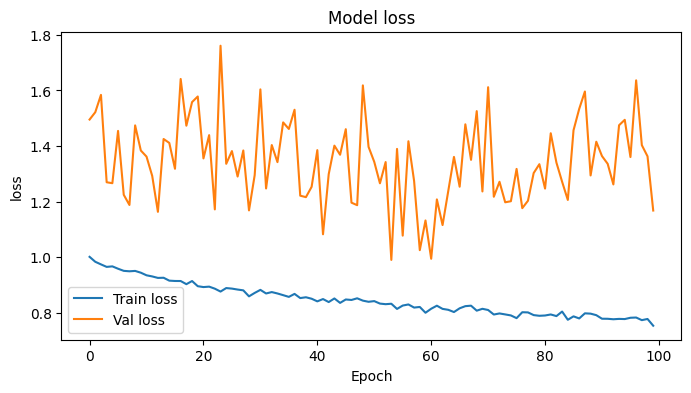

In [157]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label='Train loss')
plt.plot(history.history['val_loss'], label=f'Val loss')
plt.title(f'Model loss')
plt.ylabel("loss")
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Predicción de residuos (test)

In [177]:
y_pred_scaled = model.predict(X_test_model, verbose=0)
y_pred_rnn = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_rnn = scaler_y.inverse_transform(y_test_model.reshape(-1, 1)).flatten()

In [178]:
resultado_rnn_test = calculate_metrics(y_test_rnn, y_pred_rnn)
pd.DataFrame([resultado_rnn_test])

,MAPE,MAE,RMSE,MSE,R2
0,1.061287,23.830782,27.673067,765.79862,0.455378


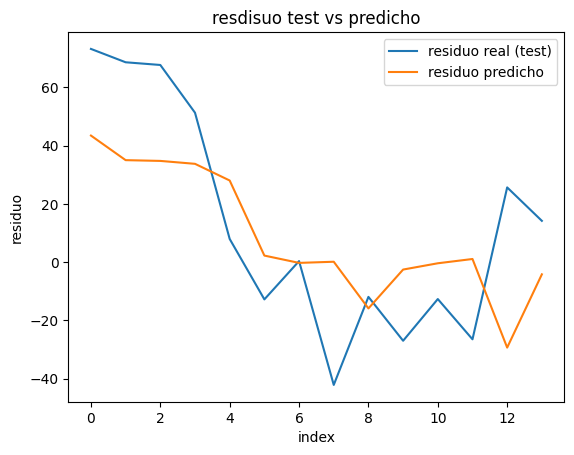

In [179]:
plt.figure()
plt.plot(y_test_rnn, label='residuo real (test)')
plt.plot(y_pred_rnn, label='residuo predicho')
plt.title('resdisuo test vs predicho')
plt.xlabel('index')
plt.ylabel('residuo')
plt.legend()
plt.show()

In [180]:
def predict_next_14_days(residuals_last_14_days, festivos_next_14_days, sarimax_model, rnn_model, residuals_scaler):
    """
    Predice los próximos 14 días utilizando los modelos SARIMAX y RNN combinados.
    """
    residuals_last_14_days = np.array(residuals_last_14_days)
    festivos_next_14_days = np.array(festivos_next_14_days)

    # Escalar los residuos de entrada
    residuals_scaled = residuals_scaler.transform(residuals_last_14_days.reshape(-1, 1))
    n_steps_in = residuals_scaled.shape[0]
    X_input_rnn = residuals_scaled.reshape((1, n_steps_in, 1))


    predicted_residuals = []
    for _ in range(14):

        y_pred_residual_scaled = rnn_model.predict(X_input_rnn, verbose=0)
        y_pred_residual = residuals_scaler.inverse_transform(y_pred_residual_scaled).flatten()[0]

        predicted_residuals.append(y_pred_residual)

        X_input_rnn = np.roll(X_input_rnn, -1, axis=1)
        X_input_rnn[0, -1, 0] = y_pred_residual_scaled.flatten()[0]

    sarimax_forecast = sarimax_model.get_forecast(steps=14, exog=festivos_next_14_days)
    sarimax_pred = sarimax_forecast.predicted_mean.values

    hybrid_pred = sarimax_pred + np.array(predicted_residuals)

    return sarimax_pred, predicted_residuals, hybrid_pred


In [181]:
residuals_last_14_days = resid_serie.tail(14).tolist()
festivos_next_14_days = exo_var_test.tolist()

sar_prd, rnn_pred, final_predict = predict_next_14_days(
        residuals_last_14_days,
        festivos_next_14_days,
        sarimax_fit, 
        model, 
        scaler_y)

In [182]:
y_true, y_pred = test_serie, final_predict
resultado_test_hibry = calculate_metrics(y_true, y_pred)
model_summary.append(pd.DataFrame([resultado_test_hibry], index=["Hibrido_test"]))
pd.DataFrame([resultado_test_hibry])

,MAPE,MAE,RMSE,MSE,R2
0,0.026083,45.122011,59.538148,3544.791085,0.888739


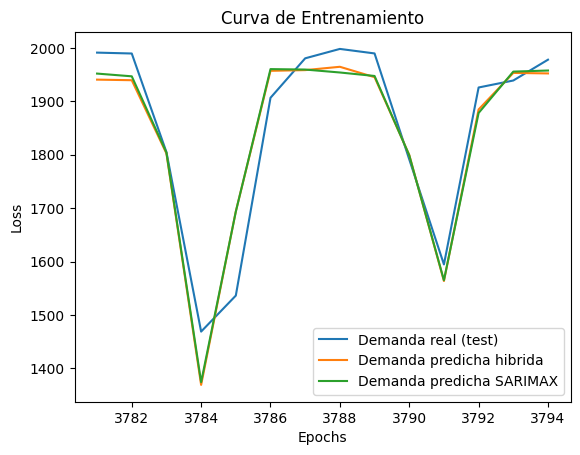

In [183]:
plt.figure()
plt.plot(test_serie.index, y_true, label='Demanda real (test)')
plt.plot(test_serie.index, y_pred, label='Demanda predicha hibrida')
plt.plot(test_serie.index, sar_prd, label='Demanda predicha SARIMAX')
plt.title('Curva de Entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [184]:
model_summary_df = pd.concat(model_summary)

In [185]:
model_summary_df

,MAPE,MAE,RMSE,MSE,R2
SARIMAX_train,0.030635,53.308904,85.633482,7333.093303,0.816442
SARIMAX_val,0.013470,24.684192,35.363633,1250.586568,0.927849
SARIMAX_test,0.025891,44.925638,57.593510,3317.012375,0.895888
Hibrido_test,0.026083,45.122011,59.538148,3544.791085,0.888739



Como se observa SARIMAX muestra un buen rendimiento en entrenamiento (MSE = 7333, R2 = 0.8164) y mejora en test (MSE = 3317.01, R2 = 0.9278). Esto seguramente por pandemia, dónde el modelo tiene menor desempeño al predecir. 

En compración con los modelos realizados para el bechmark, los sarimax ofrecen un mejor desempeño. Esto indica que el modelo logra capturar las dinámicas subyacentes de la serie temporal de manera efectiva, permitiendo predicciones más precisas. Además, se concluye que si bien un enfoque híbrido promete mejorar las predicciones, en este caso (con los cambios realizados según las recomendaciones del profesor) el modelo no explica la varabilidad contenida en los residuos, por tanto, no presenta una diferencia significativa con el sarimax propuesto. 



In [186]:
model_summary_df.to_csv("model_summary_v2.csv")